# **Real Disaster Prediction from Disaster Tweets using Natural Language Processing**



### Objective

1. Perform data preprocessing
2.  Predicting whether a given tweet is about a real disaster or not?
3.  Build and test the model for test data
4.  Evaluate the quality of the trained models

----

### About Dataset

1.   List item
2.   List item



This dataset taken from kaggle competition called [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview)

This dataset was created by the company figure-eight and originally shared on their ‘[Data For Everyone](https://appen.com/data-for-everyone/)*’* website here.



#### Importing Datasets

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


#### Import and install Libraries

In [2]:
!pip install gensim
!pip install tensorflow
!pip install --upgrade nltk
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 41.8 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


In [3]:
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim.utils import simple_preprocess

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import FreqDist
from nltk.tokenize import word_tokenize

import tensorflow as tf

from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow import keras
import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
nltk.data.path.append('/usr/share/nltk_data/corpora/wordnet.zip')
nltk.data.path.append("/kaggle/input/corpora/wordnet.zip")

#### Load the Disaster Tweets dataset

Let's have a look at the train and test dataset.

They contain:

- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [7]:
df_train=pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
df_train.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
df_test=pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


#### Explore the dataset

In [11]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
 5   length    7613 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 357.0+ KB


If you want to know more information about the data, you can grab useful information [here](https://www.kaggle.com/code/alexia/kerasnlp-starter-notebook-disaster-tweets?scriptVersionId=138734217&cellId=10)

Note that all the tweets are in english.

#### Preprocess the data

In [13]:
lemmatizer=WordNetLemmatizer() # Intitialize lemmstizer

In [14]:
def preprocess(df):
  corpus=[]
  words=[]
  for i in range(0, len(df)):                           ## Text cleaning and lemmatizing the tweets
    review = re.sub('[^a-zA-Z0-9]', ' ', df['text'][i])
    review = review.lower()
    review = review.split()

    review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  for sent in corpus:                                   ## Tokenize the each words of the tweets
    sent_token=sent_tokenize(sent)
    for sent in sent_token:
      words.append(simple_preprocess(sent))

  return corpus, words

In [15]:
corpus_train,words_train=preprocess(df_train)
corpus_test,words_test=preprocess(df_test)

In [16]:
## Finding the vocabulary size
lst = [word for sentence in corpus_train for word in word_tokenize(sentence)]
freq_dist = FreqDist(lst)
print(freq_dist.most_common(20))
rare_threshold = 10000
rare_words_train = [word for word, freq in freq_dist.items() if freq < rare_threshold]
len(rare_words_train)

[('co', 4745), ('http', 4721), ('fire', 356), ('like', 350), ('amp', 344), ('u', 261), ('get', 255), ('new', 228), ('via', 220), ('2', 217), ('one', 209), ('people', 201), ('news', 200), ('year', 177), ('video', 175), ('time', 166), ('disaster', 161), ('emergency', 159), ('body', 155), ('day', 147)]


20187

In [17]:
lst = [word for sentence in corpus_test for word in word_tokenize(sentence)]
freq_dist = FreqDist(lst)
print(freq_dist.most_common(20))
rare_threshold = 10000
rare_words_test = [word for word, freq in freq_dist.items() if freq < rare_threshold]
len(rare_words_test)

[('co', 2069), ('http', 2059), ('fire', 167), ('amp', 166), ('like', 146), ('get', 126), ('u', 106), ('via', 105), ('new', 103), ('2', 96), ('news', 93), ('one', 90), ('people', 85), ('would', 77), ('year', 76), ('emergency', 73), ('3', 69), ('attack', 69), ('time', 66), ('disaster', 65)]


11431

In [18]:
## Total size of the vocabulary
len(rare_words_test)+len([word for word in rare_words_test if word not in rare_words_train])

17334

In [19]:
## Finding the sentence length

max([[i,j] for i,j in zip(list(map(len,corpus_train)),corpus_train)])

[137,
 'bomb crash loot riot emergency pipe bomb nuclear chemical spill gas ricin leak violence drug cartel cocaine marijuana heroine kidnap bust']

In [20]:
max([[i,j] for i,j in zip(list(map(len,corpus_test)),corpus_test)])

[132,
 'harvardu 90blks amp 8whts colluded 2 take wht f usagov auth hostage amp 2 make look blk w bioterrorism amp use lgl org idis id still']

In [21]:
## Defining the Vocabulary size, sentence lenth, and Dimension for vector
voc_size=18000
sent_length=30
embedding_vector_features=128

##### One Hot Encoding and Padding

In [22]:
onehot_repr_train=[one_hot(words,voc_size) for words in corpus_train]
onehot_repr_train[1]

[8091, 12200, 3198, 10174, 5417, 10965, 5349]

In [23]:
corpus_train[1]

'forest fire near la ronge sask canada'

In [24]:
onehot_repr_test=[one_hot(words,voc_size) for words in corpus_test]
onehot_repr_test[1]

[15442, 11650, 1887, 6369, 7646, 13531, 6110]

In [25]:
corpus_test[1]

'heard earthquake different city stay safe everyone'

In [26]:
embedded_doc_train=pad_sequences(onehot_repr_train,padding='pre',maxlen=sent_length)
embedded_doc_train[1]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,  8091, 12200,  3198, 10174,
        5417, 10965,  5349], dtype=int32)

In [27]:
embedded_doc_test=pad_sequences(onehot_repr_test,padding='pre',maxlen=sent_length)

In [28]:
X=np.array(embedded_doc_train)
Y=np.array(df_train['target'])

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.40, random_state=0)

X_test=np.array(embedded_doc_test)

#### Bulding,Training and Evaluating the Model

In [30]:
## Model Build

model = Sequential()
model.add(Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(50)))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(units=1, activation=None))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=keras.optimizers.Adam(learning_rate=1e-5, clipvalue=0.5),metrics=['accuracy'])

In [31]:
## Model Summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 128)           2304000   
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 batch_normalization (Batch  (None, 30, 128)           512       
 Normalization)                                                  
                                                                 
 bidirectional (Bidirection  (None, 100)               71600     
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 100)               4

In [32]:
## Early Stopping

early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [33]:
## Training the model

model_history = model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs=50, batch_size = 32, callbacks = early_stopping)

Epoch 1/50
143/143 [==============================] - 24s 109ms/step - loss: 0.8555 - accuracy: 0.5467 - val_loss: 0.6767 - val_accuracy: 0.5785
Epoch 2/50
143/143 [==============================] - 6s 39ms/step - loss: 0.8342 - accuracy: 0.5535 - val_loss: 0.6731 - val_accuracy: 0.5785
Epoch 3/50
143/143 [==============================] - 4s 25ms/step - loss: 0.8228 - accuracy: 0.5713 - val_loss: 0.6589 - val_accuracy: 0.5785
Epoch 4/50
143/143 [==============================] - 4s 25ms/step - loss: 0.7942 - accuracy: 0.5807 - val_loss: 0.6517 - val_accuracy: 0.5949
Epoch 5/50
143/143 [==============================] - 3s 19ms/step - loss: 0.8081 - accuracy: 0.5711 - val_loss: 0.6630 - val_accuracy: 0.6133
Epoch 6/50
143/143 [==============================] - 2s 15ms/step - loss: 0.7876 - accuracy: 0.5787 - val_loss: 0.6661 - val_accuracy: 0.6225
Epoch 7/50
143/143 [==============================] - 2s 17ms/step - loss: 0.7787 - accuracy: 0.5805 - val_loss: 0.6642 - val_accuracy: 0.62

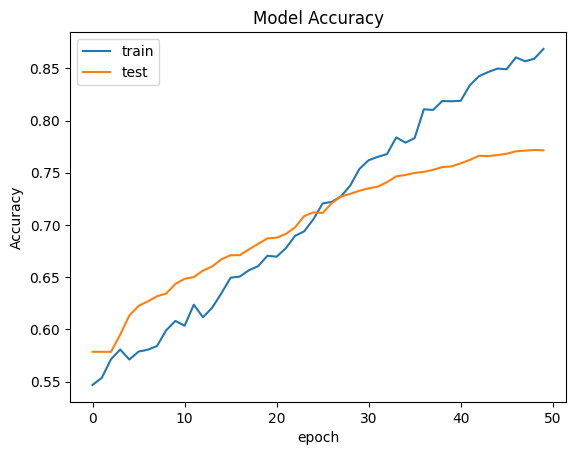

In [34]:
## Visualizing the Accuracy of model training
plt.plot(model_history.history[ 'accuracy'])
plt.plot(model_history.history[ 'val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(['train','test'], loc='upper left')
plt.show()

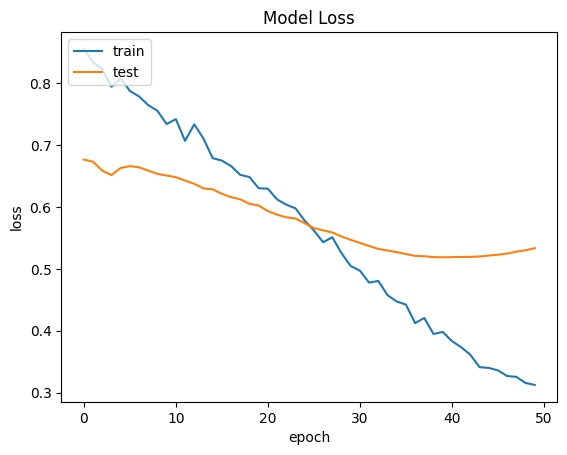

In [35]:
## Visualizing the model loss in training

plt.plot(model_history.history[ 'loss'])
plt.plot(model_history.history[ 'val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [36]:
y_pred=model.predict(X_val) ## Prediciting the validation data

96/96 [==============================] - 1s 3ms/step


In [37]:
y_pred=np.where(y_pred > 0.6, 1,0) ##AUC ROC Curve

In [38]:
confusion_matrix(y_val,y_pred)  ## Confusion matrix for validation data

array([[1561,  201],
       [ 494,  790]])

In [39]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true,y_pred).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

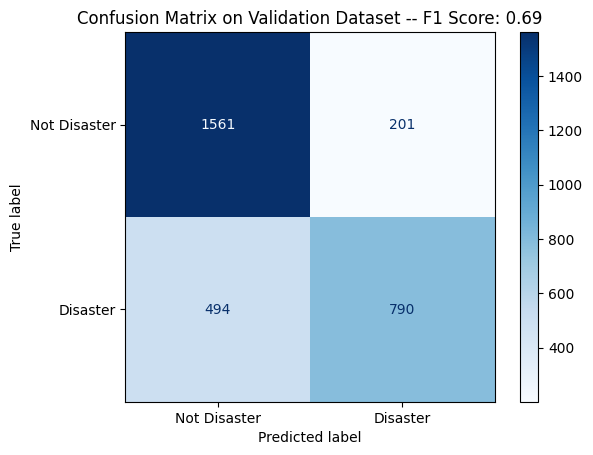

In [40]:
displayConfusionMatrix(y_val, y_pred, "Validation")

In [41]:
accuracy_score(y_val,y_pred)

0.7718319107025607

In [42]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1762
           1       0.80      0.62      0.69      1284

    accuracy                           0.77      3046
   macro avg       0.78      0.75      0.76      3046
weighted avg       0.78      0.77      0.77      3046



In [43]:
y_pred=np.where( model.predict(X_train)> 0.6, 1,0)

143/143 [==============================] - 0s 3ms/step


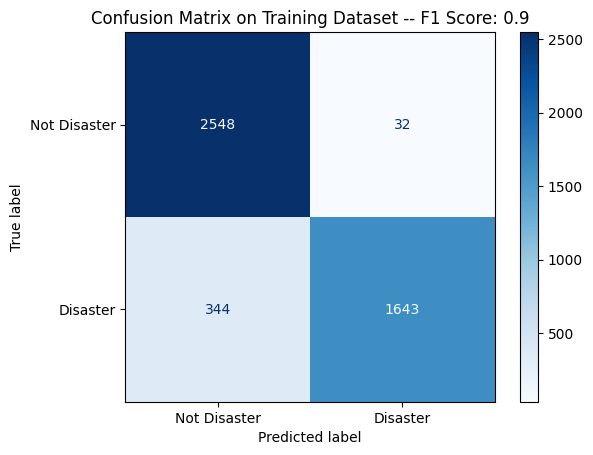

In [44]:
displayConfusionMatrix(y_train, y_pred, "Training")

In [45]:
accuracy_score(y_train,y_pred)

0.9176702430479527

In [46]:
print(classification_report(y_train,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2580
           1       0.98      0.83      0.90      1987

    accuracy                           0.92      4567
   macro avg       0.93      0.91      0.91      4567
weighted avg       0.92      0.92      0.92      4567



#### Hyperparameter Tuning

In [47]:
def model_builder(hp):
  model = Sequential()
  hp_dim = hp.Int('dim', min_value=32, max_value=168, step=32)
  model.add(Embedding(voc_size, hp_dim, input_length=sent_length))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  hp_units1 = hp.Int('units1', min_value=10, max_value=100, step=10)
  model.add(Bidirectional(LSTM(hp_units1)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
    
  model.add(Dense(units=1, activation=None))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate, clipvalue=0.5),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [48]:
tuner = kt.RandomSearch(model_builder,
                     objective='val_accuracy',
                     max_trials=50,
                     directory='Tuner',
                     project_name='Cluster_war')

In [49]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [50]:
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val,y_val), callbacks=[stop_early])

Trial 50 Complete [00h 00m 38s]
val_accuracy: 0.7731450796127319

Best val_accuracy So Far: 0.782337486743927
Total elapsed time: 00h 55m 28s


In [51]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

#print(f"""
#The hyperparameter search is complete. The optimal number of units in the Bidirectional LSTM
#layer is {best_hps.get('units1')} and The optimal number of units in the LSTM
#layer is {best_hps.get('units2')} and The optimal learning rate for the optimizer
#is {best_hps.get('learning_rate')} and The optimal number of dimesnion is {best_hps.get('dim')}."""
#)

In [52]:
#model = tuner.hypermodel.build(best_hps)
#history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val,y_val))

#val_acc_per_epoch = history.history['val_accuracy']
#best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
#print('Best epoch: %d' % (best_epoch,))

In [53]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=10, validation_data=(X_val,y_val), callbacks=[stop_early])

Epoch 1/10
143/143 [==============================] - 18s 93ms/step - loss: 0.8079 - accuracy: 0.5700 - val_loss: 0.6739 - val_accuracy: 0.5785
Epoch 2/10
143/143 [==============================] - 4s 28ms/step - loss: 0.7095 - accuracy: 0.6144 - val_loss: 0.6600 - val_accuracy: 0.5785
Epoch 3/10
143/143 [==============================] - 3s 22ms/step - loss: 0.6081 - accuracy: 0.6854 - val_loss: 0.6002 - val_accuracy: 0.5890
Epoch 4/10
143/143 [==============================] - 3s 18ms/step - loss: 0.4851 - accuracy: 0.7718 - val_loss: 0.4963 - val_accuracy: 0.7580
Epoch 5/10
143/143 [==============================] - 2s 16ms/step - loss: 0.3672 - accuracy: 0.8364 - val_loss: 0.5114 - val_accuracy: 0.7781
Epoch 6/10
143/143 [==============================] - 2s 13ms/step - loss: 0.3107 - accuracy: 0.8662 - val_loss: 0.5418 - val_accuracy: 0.7751
Epoch 7/10
143/143 [==============================] - 2s 13ms/step - loss: 0.2522 - accuracy: 0.8936 - val_loss: 0.5824 - val_accuracy: 0.779

In [54]:
eval_result = hypermodel.evaluate(X_val, y_val)
print("[test loss, test accuracy]:", eval_result)

96/96 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.7731
[test loss, test accuracy]: [0.6310279965400696, 0.7731450796127319]


In [55]:
y_pred=model.predict(X_val) ## Prediciting the validation data

96/96 [==============================] - 0s 3ms/step


In [56]:
y_pred=np.where(y_pred > 0.6, 1,0) ##AUC ROC Curve

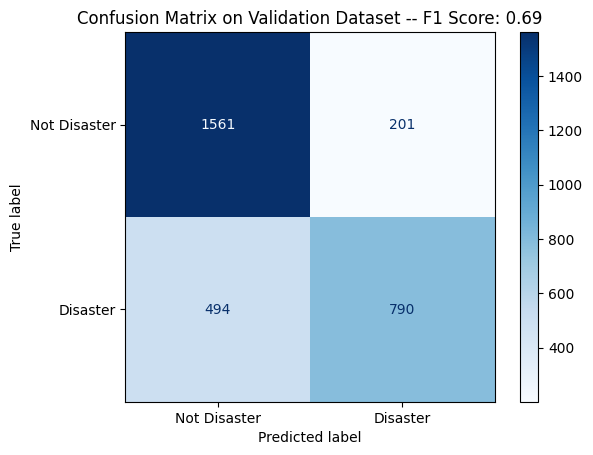

In [57]:
displayConfusionMatrix(y_val, y_pred, "Validation")

In [58]:
accuracy_score(y_val,y_pred)

0.7718319107025607

In [59]:
y_pred=np.where( model.predict(X_train)> 0.6, 1,0)

143/143 [==============================] - 0s 3ms/step


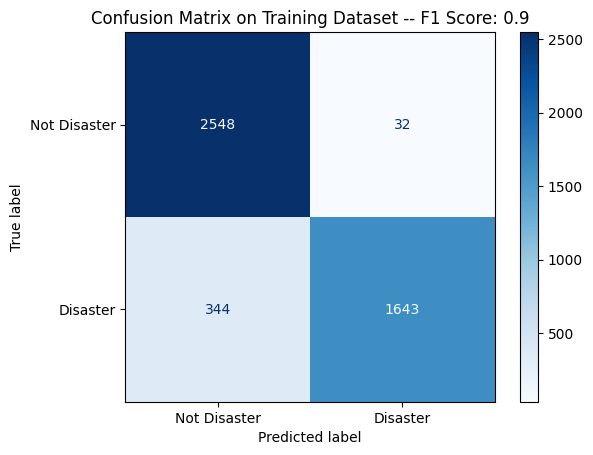

In [60]:
displayConfusionMatrix(y_train, y_pred, "Training")

In [61]:
accuracy_score(y_train,y_pred)

0.9176702430479527

#### Generate the submission file

For each tweets in the test set, we predict if the given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

The submission.csv file uses the following format: id,target

In [62]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [63]:
sample_submission["target"] =np.where(model.predict(X_test)> 0.6, 1,0)

102/102 [==============================] - 0s 3ms/step


In [64]:
sample_submission["target"]

0       0
1       0
2       1
3       0
4       1
       ..
3258    0
3259    1
3260    1
3261    1
3262    0
Name: target, Length: 3263, dtype: int64

In [65]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.317806
std,3146.427221,0.465695
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [66]:
sample_submission.to_csv("/kaggle/working/submission.csv", index=False)